In [ ]:
import pandas as pd
import numpy as np
from shapely.geometry import box
from skysurvey import Survey
from skysurvey.tools.utils import get_skynoise_from_maglimit
from skysurvey.target import SNeIa
from skysurvey.target import core
from shapely.ops import unary_union
from skysurvey.effects import mw_extinction
import matplotlib.pyplot as plt
from skysurvey import dataset
import matplotlib.pyplot as plt
from astropy.time import Time

import warnings
warnings.filterwarnings('ignore')

In [ ]:
parquet_path = "dp1_visits-ECDFS_EDFS_Fornax_LELF.parquet"
df = pd.read_parquet(parquet_path)

In [ ]:
df.head

In [ ]:

# Check available columns
print(df.columns)
print(df.head())



In [ ]:
# Ref
ra_center = 40.00
dec_center = -34.45
radius_deg = 1.0  # degrees

# Compute angular separation using a sphere ???
def angular_sep(ra1, dec1, ra2, dec2):
    ra1, dec1, ra2, dec2 = map(np.radians, [ra1, dec1, ra2, dec2])
    return np.degrees(
        np.arccos(
            np.sin(dec1) * np.sin(dec2) +
            np.cos(dec1) * np.cos(dec2) * np.cos(ra1 - ra2)
        )
    )

# Apply filter
mask = angular_sep(df["ra"], df["dec"], ra_center, dec_center) >= radius_deg
df_filtered = df[mask]

# Inspect result
print(df_filtered.shape)
print(df_filtered.head())

plt.scatter(df_filtered['ra'],df_filtered['dec'])

plt.scatter(df['ra'], df['dec'], s=3, alpha=0.3, label='Original')
plt.scatter(df_filtered['ra'], df_filtered['dec'], s=3, alpha=0.8, label='Filtered')
plt.legend()


In [152]:
get_skynoise_from_maglimit

<function skysurvey.tools.utils.get_skynoise_from_maglimit(maglim, zp=30)>

In [154]:
df_filtered["limitingMagnitude"].apply(get_skynoise_from_maglimit,zp=30)

0        41.121599
1        28.491151
2        27.501096
3        41.659111
4        43.330130
           ...    
1323     33.768362
1324     33.335732
1325     50.604600
1326     46.621903
1327    133.189502
Name: limitingMagnitude, Length: 1286, dtype: float64

In [156]:
simdata = pd.DataFrame({
    "skynoise": df_filtered["limitingMagnitude"].apply(get_skynoise_from_maglimit, zp=30).values,
    "mjd": df_filtered["mjd"].values,
    "band": "lsst" + df_filtered["band"].values,
    "gain": 1.0,
    "zp": 30,
    "ra": df_filtered["ra"].values,
    "dec": df_filtered["dec"].values
}, index=df_filtered.index)


In [158]:
fov_deg = 40.0 / 60.0
half_size = fov_deg / 2.0
footprint = box(-half_size, -half_size, half_size, half_size)

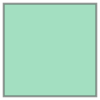

In [160]:
footprint

In [162]:
sur = Survey.from_pointings(simdata, footprint=footprint)

In [164]:
df_filtered = df_filtered.reset_index(drop=True)
#sur.show() # ???

In [166]:
sur.data

,skynoise,mjd,band,gain,zp,ra,dec,fieldid_survey,fieldid
1283,28.491152,60623.257812,lsstr,1.0,30,53.327423,-28.072346,1,351881
1335,41.121597,60623.257812,lssti,1.0,30,53.327236,-28.072054,0,351881
1980,41.121597,60623.257812,lssti,1.0,30,53.327236,-28.072054,0,352681
1981,28.491152,60623.257812,lsstr,1.0,30,53.327423,-28.072346,1,352681
3091,28.491152,60623.257812,lsstr,1.0,30,53.327423,-28.072346,1,352682
...,...,...,...,...,...,...,...,...,...
6382,50.604599,60655.28125,lsstg,1.0,30,59.13765,-48.766579,1325,420718
6386,46.621902,60655.28125,lsstg,1.0,30,59.004105,-48.754547,1326,420718
6631,133.189499,60655.28125,lsstr,1.0,30,59.225872,-48.752522,1327,420719
6642,50.604599,60655.28125,lsstg,1.0,30,59.13765,-48.766579,1325,420719


In [168]:
tiles = []
for _, row in df_filtered.iterrows():
    ra = row["ra"]
    dec = row["dec"]
    tile = box(ra - half_size, dec - half_size, ra + half_size, dec + half_size)
    tiles.append(tile)
skyarea = unary_union(tiles)

# Time range of the survey
tstart, tstop = sur.get_timerange()

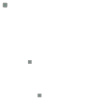

In [170]:
skyarea = unary_union(tiles)
skyarea

In [ ]:
runs_list = []
while len(runs_list) <100:
    try:
        snia = SNeIa.from_draw(
            tstart=tstart,
            tstop=tstop,
            skyarea=skyarea,
            zmin=0.1,
            zmax=1.0,  #Note : redshift changed to 2
            effect=mw_extinction,
            template='salt2-extended'
            )
        dset = dataset.DataSet.from_targets_and_survey(snia, sur,discard_bands=["lsstu"])
    except:
        print("failed")
        continue

In [173]:
print(snia.data)

          z     x1      c            t0         ra        dec     magabs  \
0   0.65145 -1.665 -0.094  60634.992188  52.720543 -28.514957 -19.309914   
1   0.98555  0.570  0.026  60654.273438  37.382137   7.567080 -19.342632   
2   0.38145 -0.715 -0.028  60626.148438  58.552032 -48.845074 -19.238424   
3   0.70825  1.510  0.091  60637.664062  53.349087 -28.453386 -19.158497   
4   0.57155 -0.150 -0.109  60631.703125  37.784199   7.513319 -19.545553   
5   0.76775  0.925  0.141  60640.742188  59.023571 -48.423847 -18.936041   
6   0.43565 -1.595  0.082  60627.406250  38.022762   7.622616 -18.821613   
7   0.96665 -1.720 -0.088  60652.968750  53.224754 -28.415604 -19.401293   
8   0.59555 -0.535 -0.187  60632.636719  59.610817 -48.765614 -19.849056   
9   0.88425  0.490  0.356  60647.562500  37.746536   6.964113 -18.226376   
10  0.79495  0.590 -0.048  60642.242188  58.795086 -48.271915 -19.641785   
11  0.82835  0.125  0.020  60644.164062  52.996346 -27.815653 -19.357992   
12  0.60785 

In [174]:
from skysurvey import dataset
dset = dataset.DataSet.from_targets_and_survey(snia, sur,discard_bands=["lsstu"])
dset.data

/Users/andradenebula/Documents/Research/Transient_Metrics/Rubin_Data_Preview_SNe/skysurvey-env/lib/python3.12/site-packages/skysurvey/dataset.py:726: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  this_survey = gsurvey_indexed.get_group(index_).copy()


fieldid   band           mjd  zp zpsys  gain    skynoise  \
index index_obs                                                             
12    2           207117  lsstg  60652.089844  30    ab   1.0   46.139194   
      5           207117  lssti  60638.144531  30    ab   1.0   78.688271   
      7           207117  lssti  60638.144531  30    ab   1.0   69.079628   
      4           207117  lsstr  60638.121094  30    ab   1.0   44.803299   
      3           207117  lsstr   60652.09375  30    ab   1.0    51.54541   
...                  ...    ...           ...  ..   ...   ...         ...   
32    6728        418634  lsstz  60653.238281  30    ab   1.0   98.217751   
      6747        418634  lsstz  60653.238281  30    ab   1.0  108.740166   
      6705        418634  lsstz  60653.242188  30    ab   1.0  106.010773   
      6712        418634  lsstz  60653.242188  30    ab   1.0  112.561531   
      6717        418634  lsstz  60653.242188  30    ab   1.0  100.348297   

                       flux     fluxerr  
index index_obs                          
12    2           26.908292   46.581787  
      5          653.160364   82.255024  
      7          697.449989   73.116621  
      4          581.506328   50.376034  
      3          136.045270   53.910204  
...                     ...         ...  
32    6728       190.061237   98.937914  
      6747       111.669431  109.391079  
      6705         8.584678  106.678324  
      6712       -19.901303  113.190456  
      6717         5.089178  101.053258  

[5264 rows x 9 columns]

In [175]:
dset.obs_index

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35, 36, 37, 39],
      dtype='int64', name='index')

In [180]:
dset.get_ndetection(per_band=True)

index  band 
0      lssti    18
       lsstr    20
       lsstz     3
2      lsstg     6
       lssti    10
                ..
30     lsstr     3
37     lssti     5
39     lssti    28
       lsstr     3
       lsstz     2
Length: 62, dtype: int64

[ 0  2  3  4  5  6  7  8 10 11 12 19 20 22 23 24 25 26 27 29 30 37 39]


23

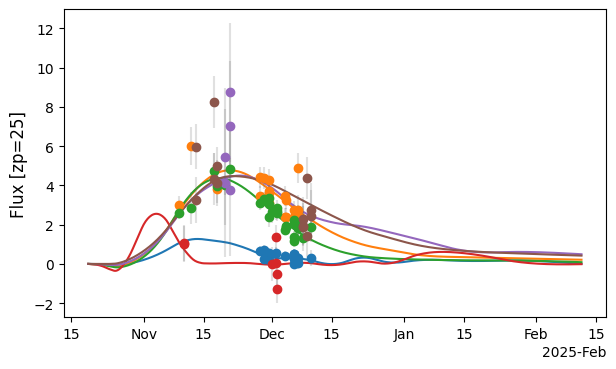

In [182]:
dset.show_target_lightcurve(index=0);

detections = dset.get_data(detection=True)
detections.to_csv("test.csv")
# Print all unique transient/event IDs that were detected
print(np.unique(detections.index.get_level_values(0).to_numpy()))
# Print the number of unique detected transients
len(np.unique(detections.index.get_level_values(0).to_numpy()))
# OPTIONAL: Count how many detections occurred in each LSST field
# print(detections.fieldid.value_counts())

In [184]:


# --- Retrieve the *full* light curve for the first transient in the dataset ---
# index=0 → the first transient/event in the simulation (not just detections)
lc0 = dset.get_target_lightcurve(index=0)
print(lc0)

# Add integer day column (for grouping) to the light curve
lc0['mjd_int'] = lc0['mjd'].astype(int)

# Compute variance from flux error (useful for weighting and SNR calculations)
lc0['variance'] = lc0['fluxerr']**2
lc0

           fieldid   band           mjd  zp zpsys  gain    skynoise  \
index_obs                                                             
5321        352683  lsstg  60642.105469  30    ab   1.0   26.178816   
5333        352683  lsstg  60643.050781  30    ab   1.0   25.032833   
5368        352683  lsstg  60643.050781  30    ab   1.0   26.894903   
5363        352683  lsstg  60644.242188  30    ab   1.0   25.637165   
5364        352683  lsstg  60644.265625  30    ab   1.0   30.683861   
...            ...    ...           ...  ..   ...   ...         ...   
5389        352683  lsstz  60652.199219  30    ab   1.0  100.468521   
5323        352683  lsstz  60653.179688  30    ab   1.0  107.544945   
5317        352683  lsstz    60653.1875  30    ab   1.0  107.426147   
5378        352683  lsstz  60654.242188  30    ab   1.0  131.458908   
5353        352683  lsstz  60654.246094  30    ab   1.0  137.997116   

                 flux     fluxerr  
index_obs                          
5321

,fieldid,band,mjd,zp,zpsys,gain,skynoise,flux,fluxerr,mjd_int,variance
index_obs,,,,,,,,,,,
5321,352683,lsstg,60642.105469,30,ab,1.0,26.178816,66.259104,27.145352,60642,736.870128
5333,352683,lsstg,60643.050781,30,ab,1.0,25.032833,24.430510,25.900589,60643,670.840512
5368,352683,lsstg,60643.050781,30,ab,1.0,26.894903,70.696596,27.704396,60643,767.533566
5363,352683,lsstg,60644.242188,30,ab,1.0,25.637165,53.306634,26.346890,60644,694.158625
5364,352683,lsstg,60644.265625,30,ab,1.0,30.683861,19.646621,31.277325,60644,978.271072
...,...,...,...,...,...,...,...,...,...,...,...
5389,352683,lsstz,60652.199219,30,ab,1.0,100.468521,194.385763,102.064253,60652,10417.111666
5323,352683,lsstz,60653.179688,30,ab,1.0,107.544945,143.761118,108.986227,60653,11877.997751
5317,352683,lsstz,60653.1875,30,ab,1.0,107.426147,437.314194,108.868596,60653,11852.371248


In [186]:

# Group the light curve by integer MJD and sum selected columns
#   flux: total flux per day (can combine multiple observations from the same night)
#   variance: total variance per day
#   band: summing doesn't make much sense numerically, but may be used for quick counts
lc0_g = lc0.groupby('mjd_int')[['flux', 'variance', 'band']].sum()


In [188]:
lc0_g

,flux,variance,band
mjd_int,,,
60623,563.920180,2911.263161,lsstilsstr
60624,206.203398,16406.492007,lsstulsstu
60626,886.822333,15388.079321,lsstilsstr
60627,923.032653,26900.471232,lsstzlsstz
60631,1730.859752,43771.498225,lsstrlsstzlsstz
60632,1691.545205,29480.992514,lsstilsstrlsstzlsstz
60634,1358.041080,267397.302100,lsstrlsstylssty
60635,2439.962525,350348.382732,lsstrlsstylsstylssty
60642,1161.484488,7911.796668,lsstglsstilsstilsstr


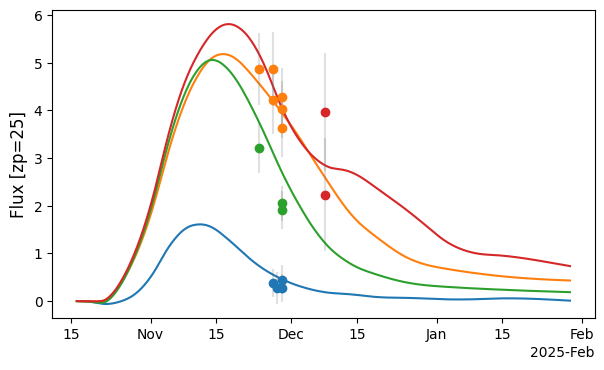

In [190]:
fig = dset.show_target_lightcurve(index=25)


In [ ]:



    

    # Unitl this point the code is similar to yesterday

    # In this function I try to merge the photometry points for a given int(MJD)
    # For each available band in a light curve and for each unique MJD, I take a weighted average of 
    # flux and fluxerr weighted by inverse of the fluxerr
    # I also make sure the datframe is same format as the dset.data
    def change_dataset_entry(dset):
        idx =  dset.obs_index.to_numpy()
        list_df_all = []

        for index in idx:
            new_data = dset.data.xs(index).copy()
            new_data['mjd_int'] = new_data['mjd'].astype(int)
            lc_band = new_data.groupby('band')
            list_df = []
            for band, df_band in lc_band:
                lc_band_g = df_band.groupby('mjd_int')
                for mjd, sub_df in lc_band_g:
                    sub_df['w'] = 1/(sub_df['fluxerr']**2)
                    sub_df['weighted_f'] = sub_df['flux']*sub_df['w']/(sub_df['w'].sum())
                    sub_df['mjd'] = mjd
                    dict={
                        'index_obs': [sub_df.index[0]],
                        'fieldid': [sub_df['fieldid'].values[0]],
                        'band': [sub_df['band'].values[0]],
                        'mjd' : [mjd],  
                        'zp'  : [30],
                        'zpsys' : ['ab'],
                        'gain'  : [1.0],
                        'skynoise' : [sub_df['skynoise'].mean()],
                        'flux' : [sub_df['weighted_f'].sum()],    
                        'fluxerr' : [np.power(sub_df['w'].sum(),-0.5)]}
                
                    list_df.append( pd.DataFrame.from_dict(dict))
                                            

            df = pd.concat(list_df)
            df.reset_index(drop=True,inplace=True)

            index_tuples = [(index, a) for a in df.index_obs]
            multi_index = pd.MultiIndex.from_tuples(index_tuples, names=['index', 'index_obs'])
            df.drop('index_obs',axis=1, inplace=True)
            df = df.set_index(multi_index)
            list_df_all.append(df)

        final_df = pd.concat(list_df_all)
        return final_df


    # For each light curve i compute the SNR and then if any entry in any band 
    # satisfies the threshold, i count them as detections 
    # This can be further changes depending on weather we want more cuts
    def num_of_detections_new(df, SNR):
        indices = np.unique(df.index.get_level_values(0).to_numpy())
        valid_light_curves = []
        valid_SNR_index = []
        for idx in indices:
            list_df = []
            lc = df.xs(idx)
            SNR_vals = lc['flux']/lc['fluxerr']
            cond = SNR_vals > SNR
            if (cond.sum() > 7) and (len(lc)>=7):
                valid_SNR_index.append(idx)
                valid_light_curves.append(lc)

        print(valid_SNR_index)
        print(f"Number of valid detections with SNR > {SNR} is {len(valid_SNR_index)}")
        return valid_SNR_index, valid_light_curves

    df = change_dataset_entry(dset)
    valid_idx, valid_lightcurves = num_of_detections_new(df, 10)
    runs_list.append(len(valid_idx))

mean = np.array(runs_list).mean()
sd = np.array(runs_list).std()

print(mean, sd)


# # Plotting individual light curves
# # The zp coedd and conversions are taken from skysurvey. Hope they are correct!!
# # This function saves N  valid ligh curves which can change between the runs
# def plot_lightcurve(i, df):
#     coef = 10 ** (-(df["zp"] - 25) / 2.5)
#     df["flux_zp"] = df["flux"] * coef
#     df["fluxerr_zp"] = df["fluxerr"] * coef

#     from matplotlib import dates as mdates        
#     locator = mdates.AutoDateLocator()
#     formatter = mdates.ConciseDateFormatter(locator)

#     fig, ax = plt.subplots()

#     ax.xaxis.set_major_locator(locator)
#     ax.xaxis.set_major_formatter(formatter)
#     grouped_df = df.groupby('band')
#     color = {
#         'lsstu' : 'blue',
#         'lsstr' : 'red',
#         'lsstg' : 'green',
#         'lssti' : 'indigo',
#         'lsstz' : 'pink',
#         'lssty' : 'yellow'
#     }
#     for group, band_df in grouped_df:
#         times = Time(band_df["mjd"], format="mjd").datetime
#         ax.scatter(times, band_df['flux_zp'],c=color[group],label=group)
#         ax.errorbar(times, band_df["flux_zp"],
#             yerr= band_df["fluxerr_zp"],
#             ls="None", marker="None", ecolor="grey", 
#             zorder=3)
#         ax.set_ylabel("Flux[zp=25]")
#         plt.legend()

#         plt.savefig(f"LC_{i}.png")



# for i, index in enumerate(valid_idx):
#     plot_lightcurve(i, valid_lightcurves[i])